In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from hydra import compose, initialize
import matplotlib.pyplot as plt
import os
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from tqdm.auto import tqdm

from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
# cfg.params.low_pass = 0.1
# cfg.params.high_pass = 4

# cfg.params.low_pass = 80
# cfg.params.high_pass = 30

cfg.params.low_pass = None
cfg.params.high_pass = None

cfg.params.stride = 15
cfg.params.window = 15

In [5]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [6]:
agent_data = get_agent_data(cfg, use_individiual_areas=True, verbose=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Only 1 valid windows could be found for section 'awake lever1' with times [-36.120676111111116, -26.045618333333337]


In [7]:
top_percent = 0.1
dose = 'high'
area = 'all'

In [8]:
def get_num_crs(delase_results, session, top_percent=0.1, area='all'):
    return delase_results[session][area].stability_params.apply(lambda x: len(x[:int(top_percent*len(x))])).sum()
def get_num_crs_pos(delase_results, session, top_percent=0.1, area='all'):
    return delase_results[session][area].stability_params.apply(lambda x: len(x[:int(top_percent*len(x))][x[:int(top_percent*len(x))] >= 0])).sum()

In [9]:
for (data_class, agent), data_dict in agent_data.items():
    print("--------------------------------")
    print(f"{agent}:")
    print("--------------------------------")
    unique_areas = np.unique(np.concatenate([list(d.keys()) for d in data_dict['delase_results'].values()]))
    delase_results = data_dict['delase_results']
    num_crs = {}
    num_crs_pos = {}
    for area in unique_areas:
        print(f"Area: {area}")
        print("---------")
        num_crs[area] = {}
        num_crs_pos[area] = {}
        for session in delase_results.keys():
            if area in delase_results[session].keys():
                num_crs[area][session] = get_num_crs(delase_results, session, top_percent, area)
                num_crs_pos[area][session] = get_num_crs_pos(delase_results, session, top_percent, area)
    
        total_crs = np.sum(list(num_crs[area].values()))
        total_crs_pos = np.sum(list(num_crs_pos[area].values()))
        total_crs_neg = total_crs - total_crs_pos
        print(f"Total CRs: {total_crs}")
        print(f"Positive CRs: {total_crs_pos} ({total_crs_pos/total_crs*100:.2f}%)")
        print(f"Negative CRs: {total_crs_neg} ({total_crs_neg/total_crs*100:.2f}%)")

--------------------------------
propofol:
--------------------------------
Area: 7b
---------
Total CRs: 798620
Positive CRs: 2030 (0.25%)
Negative CRs: 796590 (99.75%)
Area: CPB
---------
Total CRs: 772645
Positive CRs: 105 (0.01%)
Negative CRs: 772540 (99.99%)
Area: FEF
---------
Total CRs: 721600
Positive CRs: 297 (0.04%)
Negative CRs: 721303 (99.96%)
Area: vlPFC
---------
Total CRs: 772907
Positive CRs: 177 (0.02%)
Negative CRs: 772730 (99.98%)
--------------------------------
ketamine:
--------------------------------
Area: dlPFC-L
---------
Total CRs: 570567
Positive CRs: 5 (0.00%)
Negative CRs: 570562 (100.00%)
Area: dlPFC-R
---------
Total CRs: 542303
Positive CRs: 0 (0.00%)
Negative CRs: 542303 (100.00%)
Area: vlPFC-L
---------
Total CRs: 563186
Positive CRs: 161 (0.03%)
Negative CRs: 563025 (99.97%)
Area: vlPFC-R
---------
Total CRs: 554247
Positive CRs: 14 (0.00%)
Negative CRs: 554233 (100.00%)
--------------------------------
dexmedetomidine:
------------------------------

# Timecourse Plots

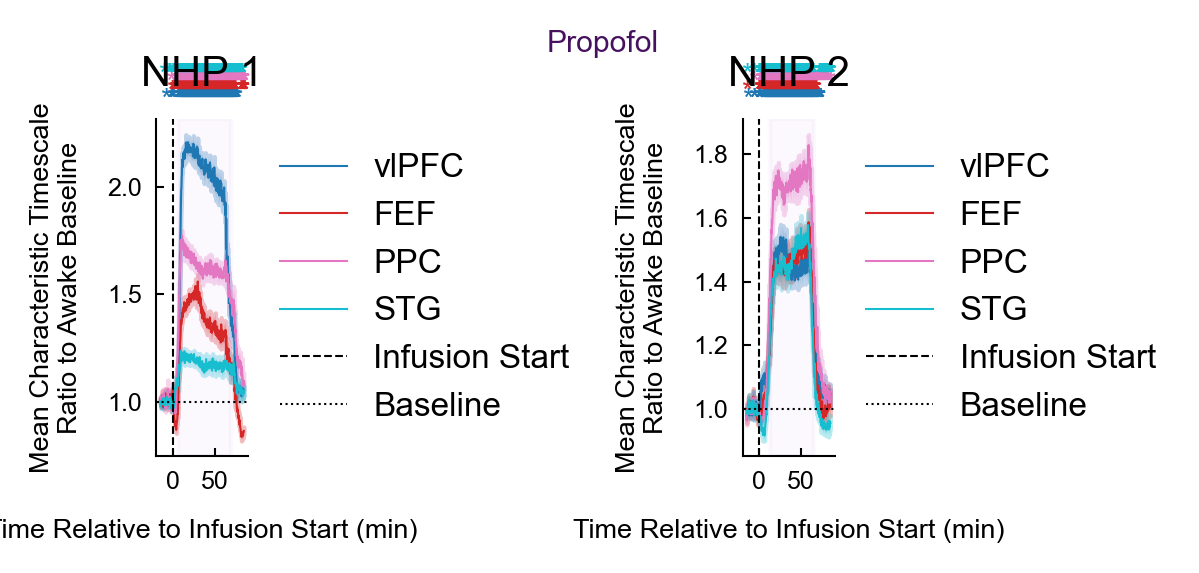

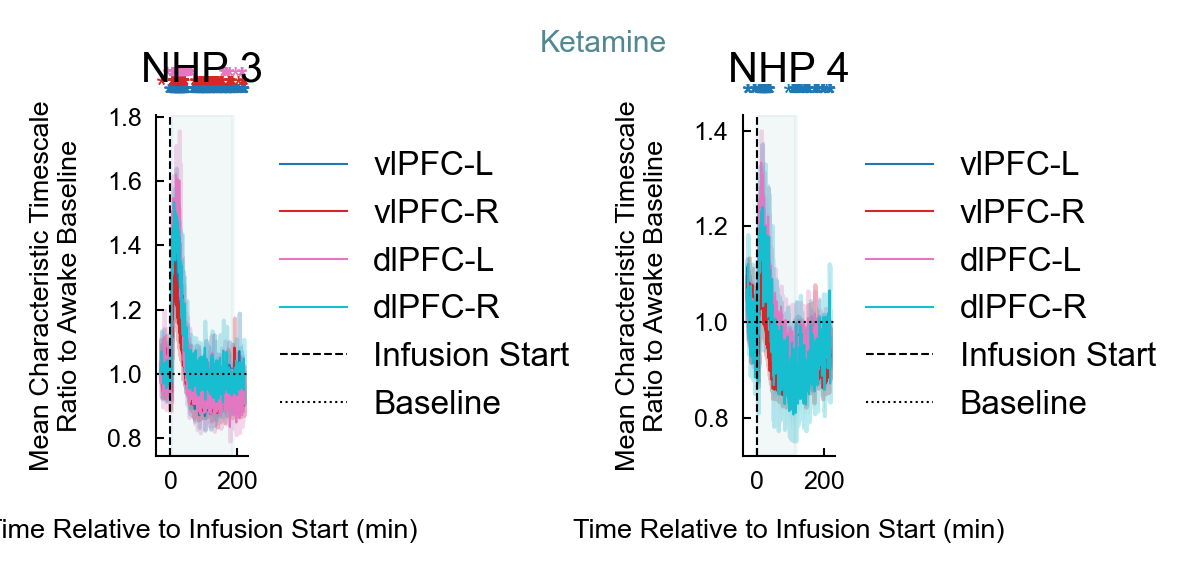

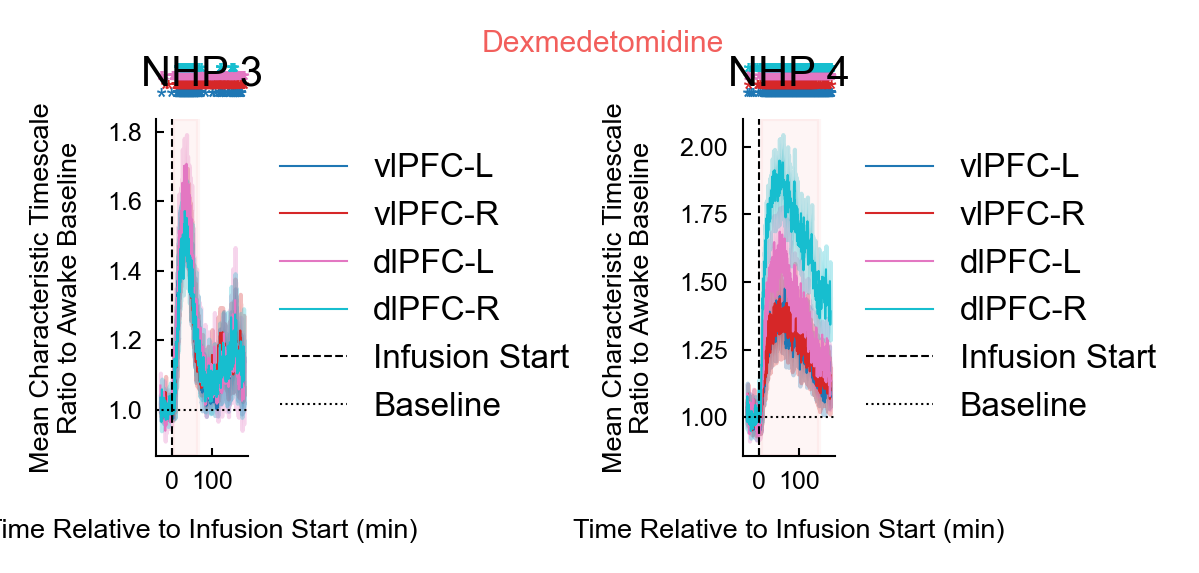

In [12]:
plot_data = {}
for (data_class, agent), data_dict in agent_data.items():
    if agent == 'propofol':
        area = ['vlPFC', 'FEF', '7b', 'CPB']
    else:
        area = ['vlPFC-L', 'vlPFC-R', 'dlPFC-L', 'dlPFC-R']
    if agent == 'propofol':
        plot_range = (-15, 85)
    elif agent == 'ketamine':
        plot_range = (-30, 220)
    else:
        plot_range = (-30, 180)
    if dose == 'high':
        save_path = os.path.join(img_save_dir, f"{agent}_timescales_grouped_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}.pdf")
    else:
        save_path = os.path.join(img_save_dir, f"{agent}_timescales_grouped_low_dose_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}.pdf")
    cfg.params.data_class = data_class
    plot_data[(data_class, agent)] = plot_session_stability_grouped(
        cfg, 
        agent, 
        data_dict['session_lists'], 
        data_dict['delase_results'], 
        data_dict['locs'], 
        data_dict['rocs'], 
        data_dict['ropaps'],
        timescales=True,
        plot_range=plot_range, 
        top_percent=top_percent, 
        curve_colors=curve_colors, 
        loc_roc_colors=loc_roc_colors, 
        figsize=(4, 2),
        dose=dose,
        save_path=save_path,
        verbose=True,
        area=area,
        return_data=True
    )


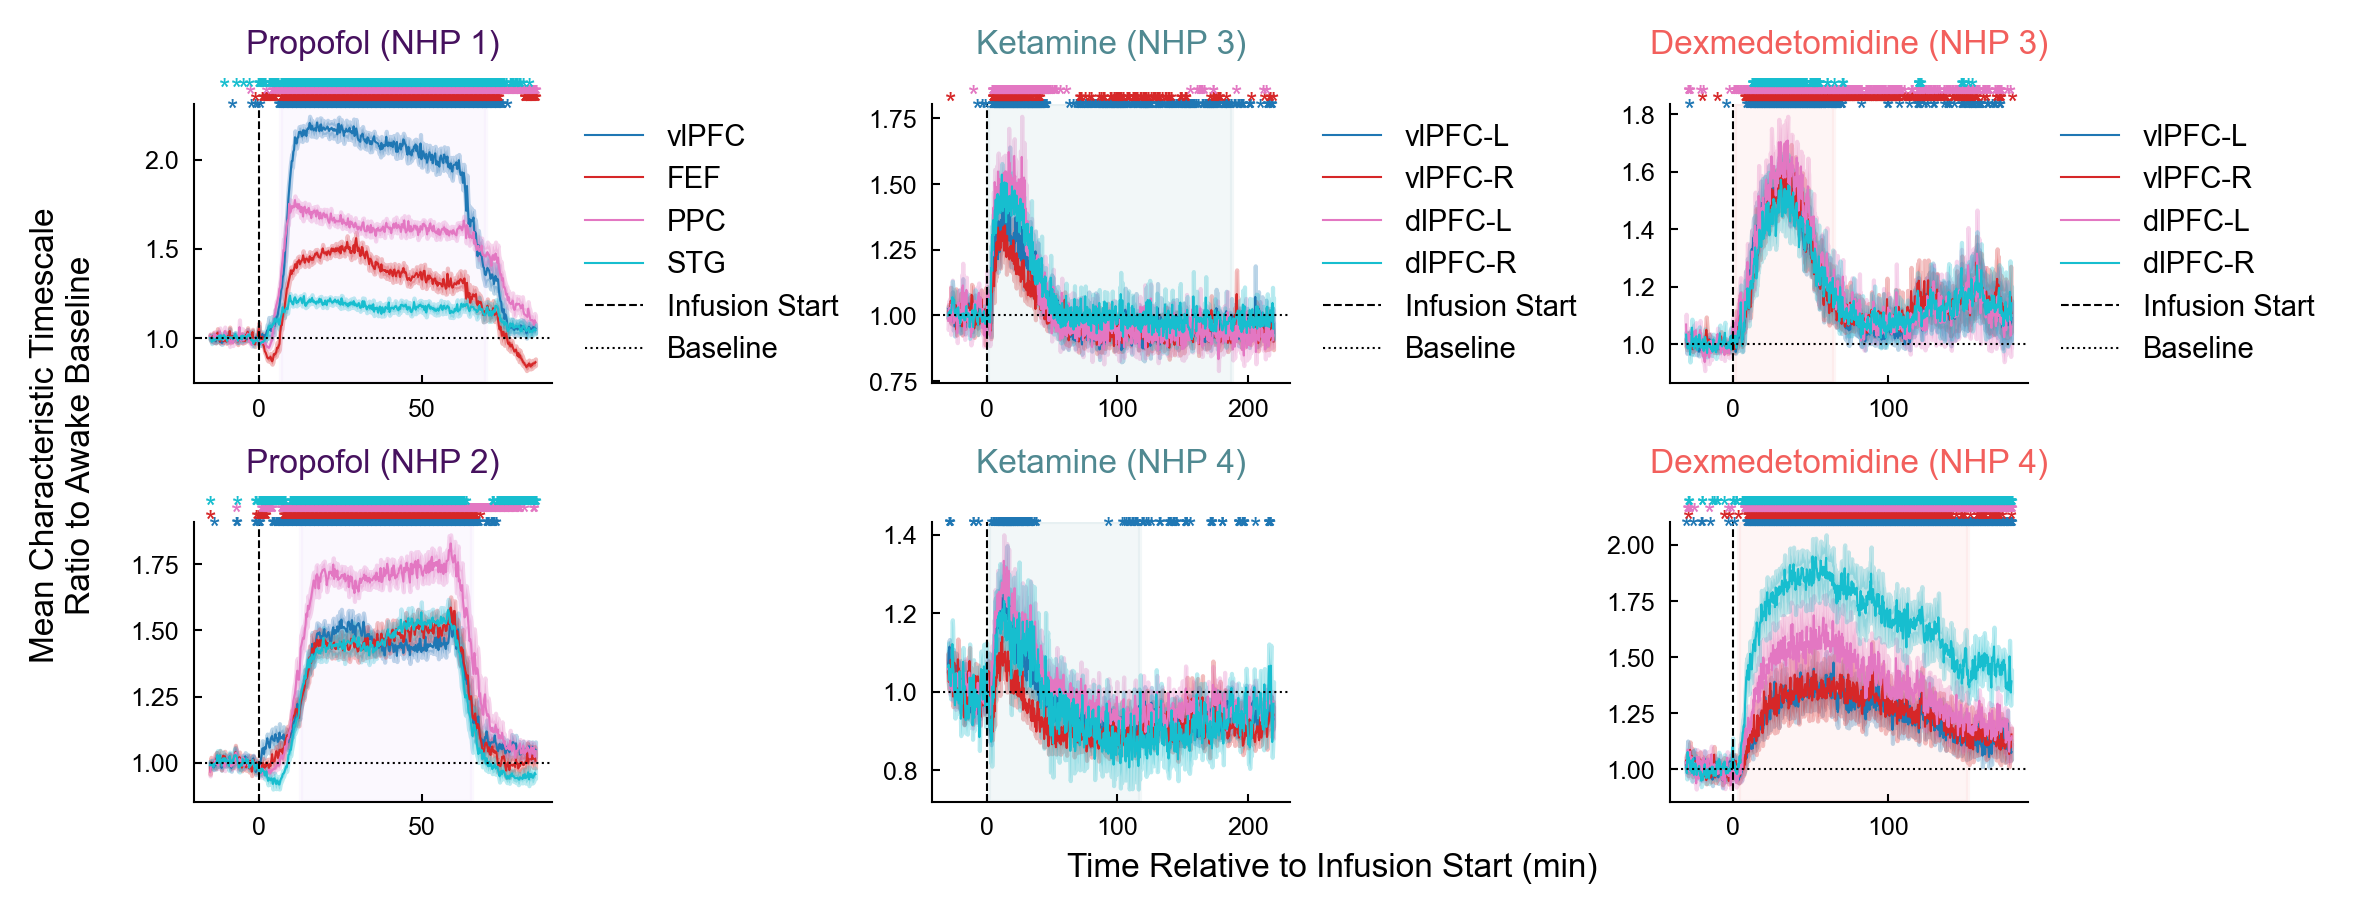

In [ ]:
# Example usage inside single-area.ipynb
grid_save_path = os.path.join(
    img_save_dir,
    'supp',
    f"timescales_grouped_grid_{cfg.params.low_pass}_{cfg.params.high_pass}_{dose}.pdf"
)

# Optional per-agent area and plot ranges (match your current notebook logic)
area_by_agent = {
    'propofol': ['vlPFC', 'FEF', '7b', 'CPB'],
    'ketamine': ['vlPFC-L', 'vlPFC-R', 'dlPFC-L', 'dlPFC-R'],
    'dexmedetomidine': ['vlPFC-L', 'vlPFC-R', 'dlPFC-L', 'dlPFC-R'],
}
plot_range_by_agent = {
    'propofol': (-15, 85),
    'ketamine': (-30, 220),
    'dexmedetomidine': (-30, 180),
}

_ = plot_session_stability_grouped_grid(
    cfg=cfg,
    agent_data=agent_data,                  # dict keyed by (data_class, agent) with session_lists, delase_results, locs, rocs, ropaps
    data_class=None,                        # or set a single data_class for all
    data_class_by_agent=None,               # or dict mapping agent -> data_class
    top_percent=top_percent,
    timescales=True,
    curve_colors=curve_colors,
    loc_roc_colors=loc_roc_colors,
    figsize=(9.0, 3.2),
    dose=dose,                              # 'high' or 'low'
    save_path=grid_save_path,               # or None to just show
    verbose=False,
    area='all',                             # used if area_by_agent is None
    area_by_agent=area_by_agent,            # per-agent areas
    plot_range_by_agent=plot_range_by_agent,
    return_data=False,                      # True to collect returned stats
    data_type='delase',
    layout='nhp_rows',
    add_legend=True
)

# Temporal Correlations

In [14]:
all_data_class_agent_session_area_monkey_combos = []
dose = 'high'
comparison_range = (-15, 85)
for (data_class, agent), data_dict in agent_data.items():
    session_lists = data_dict['session_lists']
    monkeys = list(session_lists.keys())
    for monkey in monkeys:
        for session in session_lists[monkey][dose]:
            delase_results = agent_data[(data_class, agent)]['delase_results']
            areas = list(delase_results[session].keys())
            for area in areas:
                all_data_class_agent_session_area_monkey_combos.append((data_class, agent, session, area, monkey))

num_sessions_area_monkey_combos = len(all_data_class_agent_session_area_monkey_combos)
session_correl = np.zeros((num_sessions_area_monkey_combos, num_sessions_area_monkey_combos))
for i, (data_class, agent, session1, area1, monkey1) in enumerate(all_data_class_agent_session_area_monkey_combos):
    for j, (data_class2, agent2, session2, area2, monkey2) in enumerate(all_data_class_agent_session_area_monkey_combos):
        session1_data = plot_data[(data_class, agent)]['groups'][monkey1][dose]['per_area'][area1]['per_session'][session1]['aligned_normalized']
        session2_data = plot_data[(data_class2, agent2)]['groups'][monkey2][dose]['per_area'][area2]['per_session'][session2]['aligned_normalized']
        times_1 = plot_data[(data_class, agent)]['common_times']
        times_2 = plot_data[(data_class2, agent2)]['common_times']
        comparison_bool_1 = (times_1 >= comparison_range[0]) & (times_1 <= comparison_range[1])
        comparison_bool_2 = (times_2 >= comparison_range[0]) & (times_2 <= comparison_range[1])
        clipped_data_1 = session1_data[comparison_bool_1]
        clipped_data_2 = session2_data[comparison_bool_2]
        min_len = min(len(clipped_data_1), len(clipped_data_2))
        clipped_data_1 = clipped_data_1[:min_len]
        clipped_data_2 = clipped_data_2[:min_len]
        session_correl[i, j] = np.corrcoef(clipped_data_1, clipped_data_2)[0, 1]

In [15]:
agent_list = np.array([combo[1] for combo in all_data_class_agent_session_area_monkey_combos])
unique_agents = np.unique(agent_list)
agent_mean_correl = np.zeros((len(unique_agents), len(unique_agents)))
for i, agent1 in enumerate(unique_agents):
    for j, agent2 in enumerate(unique_agents):
        agent_mean_correl[i, j] = np.mean(session_correl[agent_list == agent1, :][:, agent_list == agent2])


monkey_agent_list = np.array([f"{combo[4]}_{combo[1]}" for combo in all_data_class_agent_session_area_monkey_combos])
unique_monkey_agent_combos = np.unique(monkey_agent_list)
monkey_mean_correl = np.zeros((len(unique_monkey_agent_combos), len(unique_monkey_agent_combos)))
for i, monkey_agent_combo1 in enumerate(unique_monkey_agent_combos):
    for j, monkey_agent_combo2 in enumerate(unique_monkey_agent_combos):
        monkey_mean_correl[i, j] = np.mean(session_correl[monkey_agent_list == monkey_agent_combo1, :][:, monkey_agent_list == monkey_agent_combo2])

area_agent_list = np.array([f"{combo[3]}_{combo[1]}" for combo in all_data_class_agent_session_area_monkey_combos])
unique_area_agent_combos = np.unique(area_agent_list)
area_mean_correl = np.zeros((len(unique_area_agent_combos), len(unique_area_agent_combos)))
for i, area_agent_combo1 in enumerate(unique_area_agent_combos):
    for j, area_agent_combo2 in enumerate(unique_area_agent_combos):
        area_mean_correl[i, j] = np.mean(session_correl[area_agent_list == area_agent_combo1, :][:, area_agent_list == area_agent_combo2])

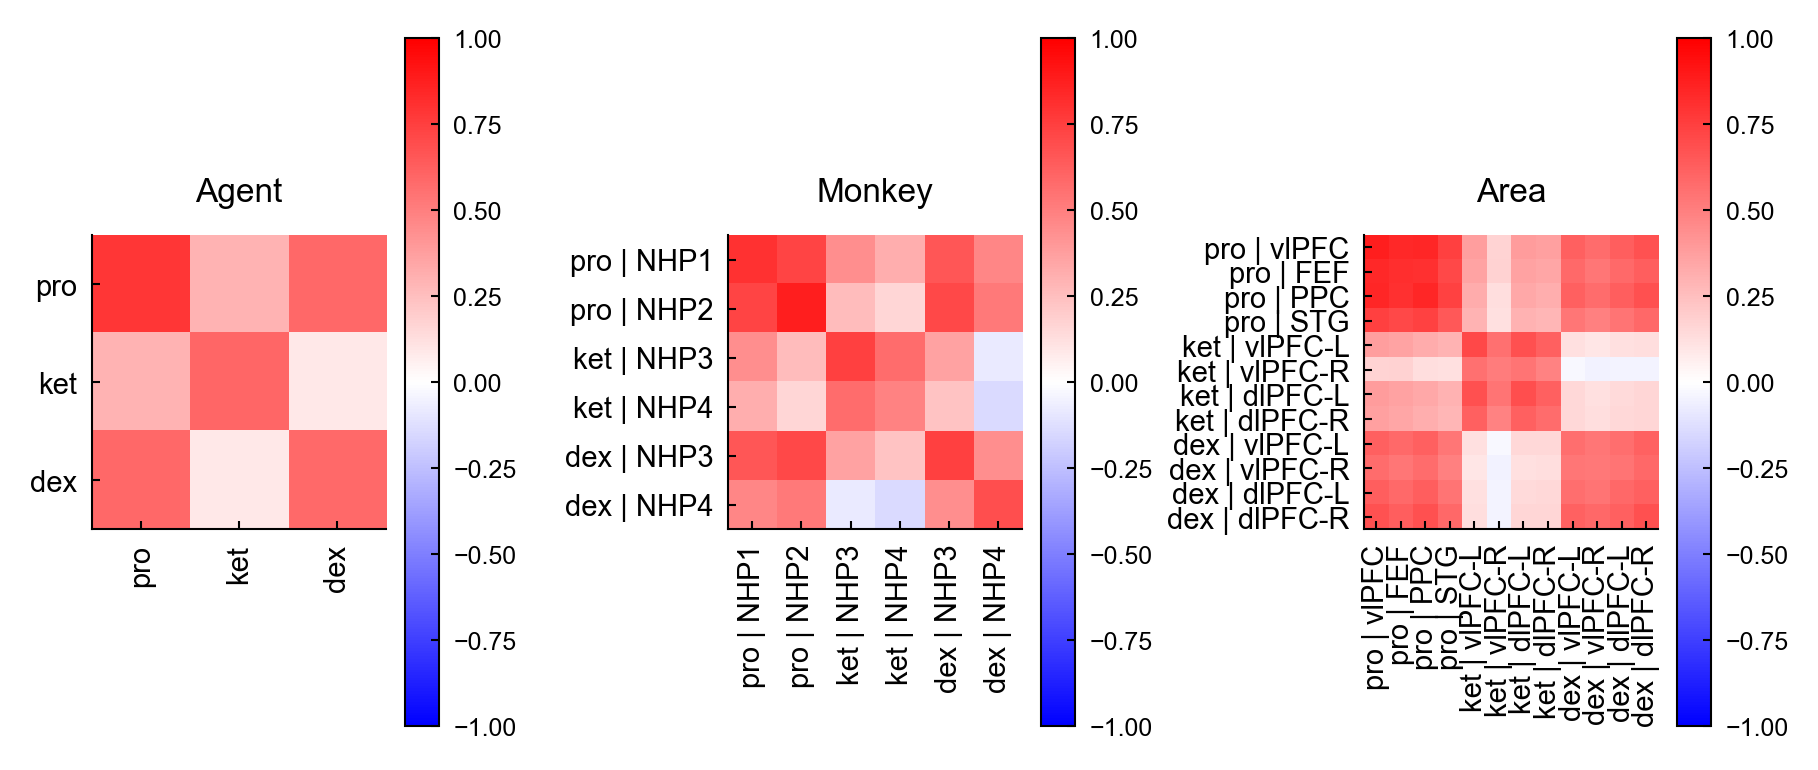

In [18]:
from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

unique_agents_plot_names = [ag[:3] for ag in unique_agents]

monkey_map = {
    'Mary': 'NHP1',
    'MrJones': 'NHP2',
    'SPOCK': 'NHP3',
    'PEDRI': 'NHP4',
}
area_names = {
    'vlPFC': 'vlPFC',
    'FEF': 'FEF',
    '7b': 'PPC',
    'CPB': 'STG',
    'vlPFC-L': 'vlPFC-L',
    'vlPFC-R': 'vlPFC-R',
    'dlPFC-L': 'dlPFC-L',
    'dlPFC-R': 'dlPFC-R',
}
unique_monkey_agent_combos_plot_names = [f"{combo.split('_')[1][:3]} | {monkey_map[combo.split('_')[0]]}" for combo in unique_monkey_agent_combos]

unique_area_agent_combos_plot_names = [f"{combo.split('_')[1][:3]} | {area_names[combo.split('_')[0]]}" for combo in unique_area_agent_combos]

fig, axs = plt.subplots(1, 3, figsize=(6, 4))

# Agent mean correlation matrix, sorted by agent_order
agent_order = ['propofol', 'ketamine', 'dexmedetomidine']

# Map unique_agents to their order in agent_order
agent_sort_index = np.array([agent_order.index(ag) for ag in unique_agents])
unique_agents_sorted = unique_agents[agent_sort_index.argsort()]
unique_agents_plot_names_sorted = [unique_agents_plot_names[i] for i in agent_sort_index.argsort()]
agent_mean_correl_sorted = agent_mean_correl[np.ix_(agent_sort_index.argsort(), agent_sort_index.argsort())]

im0 = axs[0].imshow(agent_mean_correl_sorted, cmap='bwr', norm=norm)
axs[0].set_title('Agent')
cbar0 = fig.colorbar(im0, ax=axs[0], shrink=0.6, aspect=20)
axs[0].set_xticks(np.arange(len(unique_agents_sorted)))
axs[0].set_yticks(np.arange(len(unique_agents_sorted)))
axs[0].set_xticklabels(unique_agents_plot_names_sorted, rotation=90, fontsize=7)
axs[0].set_yticklabels(unique_agents_plot_names_sorted, fontsize=7)

# Sort monkey-agent combos by agent as (pro, then ket, then dex), then by monkey order (NHP3, NHP4, NHP1, NHP2)
agent_order = ['propofol', 'ketamine', 'dexmedetomidine']
monkey_order = ['NHP1', 'NHP2','NHP3', 'NHP4']

# Helper for plotting name
def get_monkey_label(x):
    monkey_label = x.split('_')[0]
    return monkey_map[monkey_label]

def get_agent_name(x):
    return x.split('_')[1]

# Compute sort keys
sort_keys = [
    (agent_order.index(get_agent_name(x)), monkey_order.index(get_monkey_label(x)))
    for x in unique_monkey_agent_combos
]
monkey_agent_sort_index = np.lexsort(( [k[1] for k in sort_keys], [k[0] for k in sort_keys] ))

# Apply the sort to combos and plot names
unique_monkey_agent_combos_sorted = unique_monkey_agent_combos[monkey_agent_sort_index]
unique_monkey_agent_combos_plot_names_sorted = [unique_monkey_agent_combos_plot_names[i] for i in monkey_agent_sort_index]
# And to the correlation matrix
monkey_mean_correl_sorted = monkey_mean_correl[np.ix_(monkey_agent_sort_index, monkey_agent_sort_index)]

# Monkey-agent combo correlation matrix (sorted)
im1 = axs[1].imshow(monkey_mean_correl_sorted, cmap='bwr', norm=norm)
axs[1].set_title('Monkey')
cbar1 = fig.colorbar(im1, ax=axs[1], shrink=0.6, aspect=20)
axs[1].set_xticks(np.arange(len(unique_monkey_agent_combos_sorted)))
axs[1].set_yticks(np.arange(len(unique_monkey_agent_combos_sorted)))
axs[1].set_xticklabels(unique_monkey_agent_combos_plot_names_sorted, rotation=90, fontsize=7)
axs[1].set_yticklabels(unique_monkey_agent_combos_plot_names_sorted, fontsize=7)

# Sort area-agent combos first by agent, then by area in given order
area_order = ['vlPFC', 'FEF', '7b', 'CPB', 'vlPFC-L', 'vlPFC-R', 'dlPFC-L', 'dlPFC-R']
agent_order = ['propofol', 'ketamine', 'dexmedetomidine']

def get_area_name(combo_str):
    # expects something like "vlPFC_propofol" or "FEF_ketamine"
    return combo_str.split('_')[0]

def get_agent_name(combo_str):
    return combo_str.split('_')[1]

sort_keys = [
    (agent_order.index(get_agent_name(x)), area_order.index(get_area_name(x)))
    for x in unique_area_agent_combos
]
area_agent_sort_index = np.lexsort(([k[1] for k in sort_keys], [k[0] for k in sort_keys]))

unique_area_agent_combos_sorted = unique_area_agent_combos[area_agent_sort_index]
unique_area_agent_combos_plot_names_sorted = [unique_area_agent_combos_plot_names[i] for i in area_agent_sort_index]
area_mean_correl_sorted = area_mean_correl[np.ix_(area_agent_sort_index, area_agent_sort_index)]

# Area-agent combo correlation matrix (sorted)
im2 = axs[2].imshow(area_mean_correl_sorted, cmap='bwr', norm=norm)
axs[2].set_title('Area')
cbar2 = fig.colorbar(im2, ax=axs[2], shrink=0.6, aspect=20)
axs[2].set_xticks(np.arange(len(unique_area_agent_combos_sorted)))
axs[2].set_yticks(np.arange(len(unique_area_agent_combos_sorted)))
axs[2].set_xticklabels(unique_area_agent_combos_plot_names_sorted, rotation=90, fontsize=7)
axs[2].set_yticklabels(unique_area_agent_combos_plot_names_sorted, fontsize=7)


plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, 'supp', "session_correl_matrix_all_areas.pdf"), bbox_inches='tight', transparent=True)
plt.show()

# Hyperparameter Table

In [10]:
# Create hyperparameter table for Word
import pandas as pd
from datetime import datetime

# Animal mapping
animal_to_nhp = {
    'Mary': 'NHP 1',
    'MrJones': 'NHP 2',
    'SPOCK': 'NHP 3',
    'PEDRI': 'NHP 4'
}

def parse_session_id(session_id):
    """Parse session ID to extract animal name and date"""
    # Handle two formats:
    # 1. Propofol: ANIMAL-Anesthesia-YYYYMMDD-NN (e.g., MrJones-Anesthesia-20160125-01)
    # 2. Ketamine/Dexmedetomidine: ANIMAL_AGENT_YYYYMMDD (e.g., PEDRI_Dexmedetomidine_20220324)
    
    if '-' in session_id:
        # Propofol format: ANIMAL-Anesthesia-YYYYMMDD-NN
        parts = session_id.split('-')
        animal = parts[0]
        # Date is in parts[2] (YYYYMMDD)
        if len(parts) >= 3:
            date_str = parts[2]
            try:
                date = datetime.strptime(date_str, '%Y%m%d')
                return animal, date
            except:
                return animal, None
        return animal, None
    else:
        # Ketamine/Dexmedetomidine format: ANIMAL_AGENT_YYYYMMDD
        parts = session_id.split('_')
        animal = parts[0]
        date_str = parts[-1]  # YYYYMMDD
        try:
            date = datetime.strptime(date_str, '%Y%m%d')
            return animal, date
        except:
            return animal, None

# Collect all hyperparameter data
table_data = []
for (data_class, agent) in anesthetic_agent_list:
    if 'grid_params_to_use' not in agent_data[(data_class, agent)]:
        continue
    
    grid_params = agent_data[(data_class, agent)]['grid_params_to_use']
    
    # Group sessions by animal and area
    animal_area_sessions = {}
    for session_id in grid_params.keys():
        animal, date = parse_session_id(session_id)
        if session_id not in grid_params:
            continue
        for area in grid_params[session_id].keys():
            key = (animal, area)
            if key not in animal_area_sessions:
                animal_area_sessions[key] = []
            animal_area_sessions[key].append((session_id, date))
    
    # Process each animal-area combination
    for (animal, area), sessions in animal_area_sessions.items():
        # Sort sessions chronologically
        sessions.sort(key=lambda x: x[1] if x[1] else datetime.max)
        
        # Get NHP number
        nhp_label = animal_to_nhp.get(animal, animal)
        
        # Add each session as a row
        for session_num, (session_id, date) in enumerate(sessions, 1):
            if area in grid_params[session_id]:
                params = grid_params[session_id][area]
                row = {
                    'Agent': agent.capitalize(),
                    'Area': area,
                    'Animal': nhp_label,
                    'Session #': session_num,
                    'n_delays': params.get('n_delays', 'N/A'),
                    'rank': params.get('rank', 'N/A')
                }
                table_data.append(row)

# Create DataFrame
df_hyperparams = pd.DataFrame(table_data)

# Sort by Agent, then Area, then Animal, then Session #
# Define custom order for Agent
agent_order = ['Propofol', 'Ketamine', 'Dexmedetomidine']
df_hyperparams['Agent'] = pd.Categorical(df_hyperparams['Agent'], categories=agent_order, ordered=True)

# Define custom order for Area
# Propofol areas: vlPFC, FEF, 7b, CPB
# Ketamine/Dexmedetomidine areas: vlPFC-L, vlPFC-R, dlPFC-L, dlPFC-R
area_order = ['vlPFC', 'FEF', '7b', 'CPB', 'vlPFC-L', 'vlPFC-R', 'dlPFC-L', 'dlPFC-R']
# Get unique areas and sort them (put known order first, then any others)
unique_areas = df_hyperparams['Area'].unique()
ordered_areas = [a for a in area_order if a in unique_areas]
other_areas = [a for a in unique_areas if a not in area_order]
final_area_order = ordered_areas + sorted(other_areas)
df_hyperparams['Area'] = pd.Categorical(df_hyperparams['Area'], categories=final_area_order, ordered=True)

# Define custom order for Animal (NHP 1, NHP 2, NHP 3, NHP 4)
animal_order = ['NHP 1', 'NHP 2', 'NHP 3', 'NHP 4']
df_hyperparams['Animal'] = pd.Categorical(df_hyperparams['Animal'], categories=animal_order, ordered=True)

# Sort the DataFrame
df_hyperparams = df_hyperparams.sort_values(['Agent', 'Area', 'Animal', 'Session #']).reset_index(drop=True)

# Display the table
print("="*100)
print("HYPERPARAMETERS TABLE (SINGLE AREA ANALYSIS)")
print("="*100)
print("\n")
print(df_hyperparams.to_string(index=False))
print("\n")

# Save as CSV (easy to import into Word)
csv_path = os.path.join(img_save_dir, 'hyperparameters_table_single_area.csv')
df_hyperparams.to_csv(csv_path, index=False)
print(f"Table saved to: {csv_path}")
print("\n")

# Create HTML table (Word can import HTML tables nicely)
html_path = os.path.join(img_save_dir, 'hyperparameters_table_single_area.html')
html_table = df_hyperparams.to_html(index=False, classes='table', table_id='hyperparameters')
with open(html_path, 'w') as f:
    f.write(html_table)
print(f"HTML table saved to: {html_path}")
print("You can open this HTML file in Word by: File > Open > Select HTML file")
print("\n")

# Also create a tab-separated version (easy to paste into Word)
tsv_path = os.path.join(img_save_dir, 'hyperparameters_table_single_area.tsv')
df_hyperparams.to_csv(tsv_path, sep='\t', index=False)
print(f"Tab-separated table saved to: {tsv_path}")
print("You can copy-paste this directly into Word")
print("\n")

# Display formatted table
print("Formatted version:")
print("="*100)
print(df_hyperparams.to_string(index=False))

HYPERPARAMETERS TABLE (SINGLE AREA ANALYSIS)


          Agent    Area Animal  Session #  n_delays  rank
       Propofol   vlPFC  NHP 1          1        11   650
       Propofol   vlPFC  NHP 1          2        12   700
       Propofol   vlPFC  NHP 1          3        11   650
       Propofol   vlPFC  NHP 1          4        10   600
       Propofol   vlPFC  NHP 1          5        12   700
       Propofol   vlPFC  NHP 1          6        11   650
       Propofol   vlPFC  NHP 1          7        11   650
       Propofol   vlPFC  NHP 1          8        12   700
       Propofol   vlPFC  NHP 1          9        12   700
       Propofol   vlPFC  NHP 1         10        12   700
       Propofol   vlPFC  NHP 2          1        11   550
       Propofol   vlPFC  NHP 2          2        12   575
       Propofol   vlPFC  NHP 2          3        11   575
       Propofol   vlPFC  NHP 2          4        11   600
       Propofol   vlPFC  NHP 2          5        12   650
       Propofol   vlPFC  